# **Preprocessing Notebook**

### In this notebook we will use FeatureTools to generate more features to help us establish relationships with our main dataframe.  We will then add our baseline model in a Logistic Regression here.

In [1]:

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, precision_score, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE




#### Let's begin again by bringing in our main dataframe and taking a quick look.

In [2]:
df_mod = pd.read_csv(f'/Users/ryanm/Desktop/df-mod.csv')
#df_mod = df_mod.drop(columns = ['product_name', 'aisle', 'department'])
print(df_mod.shape)
df_mod.head(5)

(3214874, 24)


,user_id,order_number,order_id,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,aisle_id,...,user_product_order_count,user_product_last_order,user_product_reorder_count,avg_days_between_orders,std_days_between_orders,total_orders,total_user_unique_products,user_reorder_proportion,product_popularity,avg_cart_position
0,1,1,2539329,3,9,12.0,26405,5,0,54,...,2,4,1,19.7,9.26,10,7,0.9,405,2.02
1,1,2,2398795,4,8,16.0,26088,6,1,23,...,1,2,1,19.7,9.26,10,7,0.9,247,2.99
2,1,3,473747,4,13,22.0,30450,5,1,88,...,1,3,1,19.7,9.26,10,7,0.9,1696,3.40
3,1,4,2254736,5,8,30.0,26405,5,1,54,...,2,4,1,19.7,9.26,10,7,0.9,405,2.02
4,1,5,431534,5,16,29.0,41787,8,1,24,...,1,5,1,19.7,9.26,10,7,0.9,5653,7.29


#### Before we start our baseline model let's scale the dataframe so our data is normalized.  This will not only help our output in our forthcoming Logistic Regression model but in our other models as well.

In [3]:
num_features = [
    'user_product_reorder_count',
    'user_product_last_order',
    'user_product_order_count',
    'avg_cart_position',
    'product_popularity',
    'user_reorder_proportion',
    'total_user_unique_products',
    'total_orders',
    'days_since_prior_order',
    'add_to_cart_order',
    'avg_days_between_orders',
    'std_days_between_orders'
]

existing_num_features = [feature for feature in num_features if feature in df_mod.columns]
print(f"Existing numerical features to be scaled: {existing_num_features}")

df_numerical = df_mod[existing_num_features]

scaler = StandardScaler()

df_num_scaled = scaler.fit_transform(df_numerical)
df_num_scaled = pd.DataFrame(df_num_scaled, columns = existing_num_features)

df_scaled = pd.concat([df_mod.drop(columns = existing_num_features), df_num_scaled], axis = 1)
df_scaled.head()

Existing numerical features to be scaled: ['user_product_reorder_count', 'user_product_last_order', 'user_product_order_count', 'avg_cart_position', 'product_popularity', 'user_reorder_proportion', 'total_user_unique_products', 'total_orders', 'days_since_prior_order', 'add_to_cart_order', 'avg_days_between_orders', 'std_days_between_orders']


,user_id,order_number,order_id,order_dow,order_hour_of_day,product_id,reordered,aisle_id,department_id,product_name_code,...,user_product_order_count,avg_cart_position,product_popularity,user_reorder_proportion,total_user_unique_products,total_orders,days_since_prior_order,add_to_cart_order,avg_days_between_orders,std_days_between_orders
0,1,1,2539329,3,9,26405,0,54,17,31683,...,-0.410997,-1.920683,-0.508987,0.146423,-0.76297,-0.901902,0.031628,-0.676228,1.461402,1.007456
1,1,2,2398795,4,8,26088,1,23,19,980,...,-0.551215,-1.689794,-0.513694,0.146423,-0.76297,-0.901902,0.493386,-0.543345,1.461402,1.007456
2,1,3,473747,4,13,30450,1,88,13,7124,...,-0.551215,-1.592202,-0.470523,0.146423,-0.76297,-0.901902,1.186023,-0.676228,1.461402,1.007456
3,1,4,2254736,5,8,26405,1,54,17,31683,...,-0.410997,-1.920683,-0.508987,0.146423,-0.76297,-0.901902,2.109539,-0.676228,1.461402,1.007456
4,1,5,431534,5,16,41787,1,24,4,2419,...,-0.551215,-0.666268,-0.352629,0.146423,-0.76297,-0.901902,1.994099,-0.277578,1.461402,1.007456


#### Excellent, lots of new and scaled features to add to our data for the forthcoming model.  Let's establish our X,y values and run our Logistic Regression model and see what our baseline efficiency is.

In [4]:
X = df_scaled.drop('reordered', axis = 1)
y = df_scaled['reordered']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr_y_pred = lr.predict(X_test)

lr_acc = accuracy_score(y_test, lr_y_pred)
lr_conf_matrix = confusion_matrix(y_test, lr_y_pred)
lr_cls_report = classification_report(y_test, lr_y_pred)

print("Metrics for Logistic Regression Model")
print("Accuracy: ", lr_acc)
print("Confusion Matrix: ", lr_conf_matrix)
print(lr_cls_report)

Metrics for Logistic Regression Model
Accuracy:  0.879387223453478
Confusion Matrix:  [[     0  77551]
 [     0 565424]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     77551
           1       0.88      1.00      0.94    565424

    accuracy                           0.88    642975
   macro avg       0.44      0.50      0.47    642975
weighted avg       0.77      0.88      0.82    642975



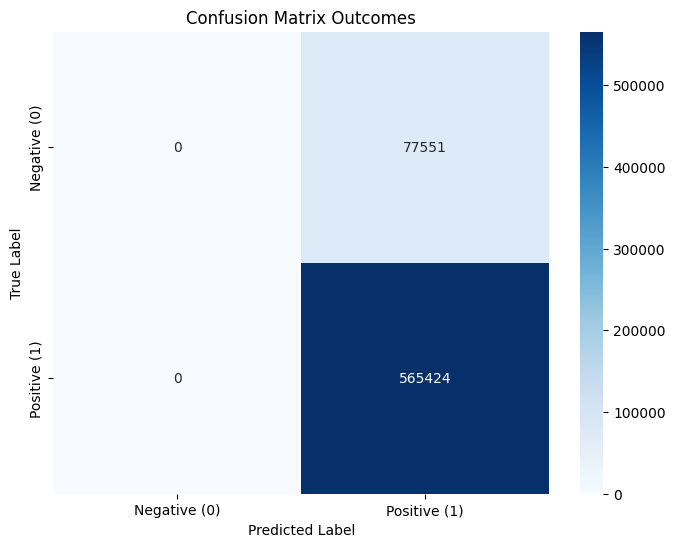

In [6]:
plt.figure(figsize = (8,6))
sns.heatmap(lr_conf_matrix, annot = True, fmt = 'd', cmap = 'Blues', xticklabels = ['Negative (0)', 'Positive (1)'], yticklabels = ['Negative (0)', 'Positive (1)'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Outcomes')
plt.show()

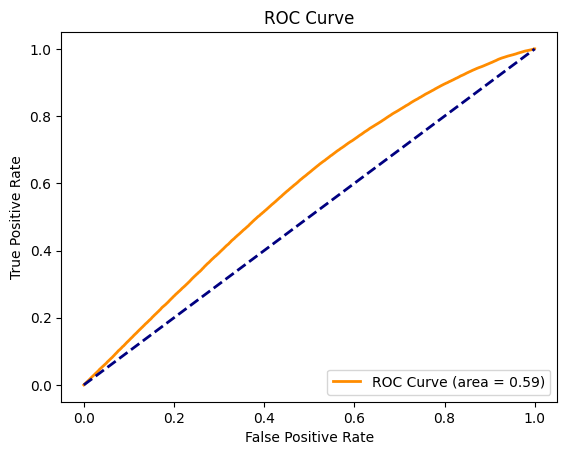

In [7]:
probs = lr.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, probs)
lr_roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color = 'darkorange', lw = 2, label = 'ROC Curve (area = %0.2f)' % lr_roc_auc)
plt.plot([0,1], [0,1], color = 'navy', lw = 2, linestyle = '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc = 'lower right')
plt.show()

#### Some observations to be made from our first model, the model didn't read the minority (0 value) very well at all.  We need to resample and rebalance the weights using SMOTE, then use GridSearchCV and run the model again to get a better outcome.

In [8]:
smote = SMOTE(random_state = 42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

param_grid = {
    'penalty' : ['l2'],
    'C' : [1, 10],
    'solver' : ['liblinear']
}

grid_search_smote = GridSearchCV(LogisticRegression(random_state = 42, max_iter = 1000),
                                param_grid,
                                cv = 3,
                                scoring = ['roc_auc', 'precision'],
                                refit = 'roc_auc',
                                n_jobs = -1)

grid_search_smote.fit(X_train_smote, y_train_smote)

best_params_smote = grid_search_smote.best_params_
best_score_smote = grid_search_smote.best_score_
print(f"SMOTE Best Parameters: {best_params_smote}")
print(f"SMOTE Best Score: {best_score_smote}")

best_model_smote = grid_search_smote.best_estimator_
y_pred_smote = best_model_smote.predict(X_test)
y_pred_proba_smote = best_model_smote.predict_proba(X_test)[:,1]

roc_score_smote = roc_auc_score(y_test, y_pred_proba_smote)
print(f"SMOTE Test ROC AUC Score: {roc_score_smote}")

print(classification_report(y_test, y_pred_smote))








SMOTE Best Parameters: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
SMOTE Best Score: 0.9160819113384129
SMOTE Test ROC AUC Score: 0.8897391058846963
              precision    recall  f1-score   support

           0       0.38      0.83      0.52     77551
           1       0.97      0.82      0.89    565424

    accuracy                           0.82    642975
   macro avg       0.68      0.82      0.70    642975
weighted avg       0.90      0.82      0.84    642975



#### Now that we have revised our Logistic Regression model let's plot again to see the differences.

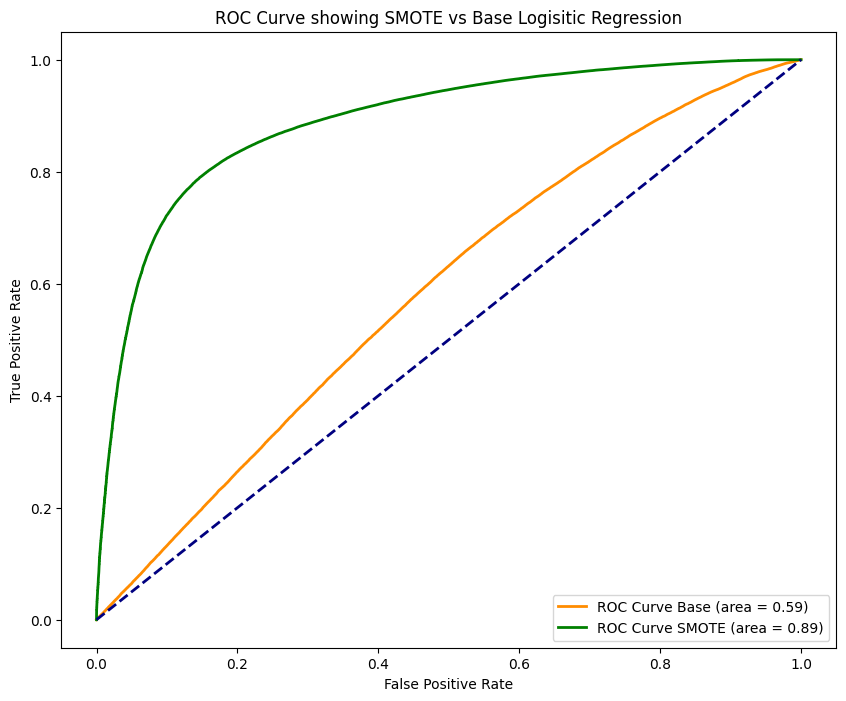

In [9]:
fpr_smote, tpr_smote, _ = roc_curve(y_test, y_pred_proba_smote)
lr_roc_auc_smote = auc(fpr_smote, tpr_smote)

plt.figure(figsize = (10,8))
plt.plot(fpr, tpr, color = 'darkorange', lw = 2, label = 'ROC Curve Base (area = %0.2f)' % lr_roc_auc)
plt.plot(fpr_smote, tpr_smote, color = 'green', lw = 2, label = 'ROC Curve SMOTE (area = %0.2f)' % lr_roc_auc_smote)
plt.plot([0,1], [0,1], color = 'navy', lw = 2, linestyle = '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve showing SMOTE vs Base Logisitic Regression')
plt.legend(loc = 'lower right')
plt.show()


#### A huge improvement.  Let's note the metrics and move on to our modeling notebook.

#### As we have done before let's save our work so we can keep using in the next notebook(s).

In [10]:
main_path = r'C:/Users/ryanm/Desktop/df-scaled.csv'


df_scaled.to_csv(main_path, index = False)